# Laboratorio Final: 
### Alumno: Martín Gonella
## "Armado de un esquema de aprendizaje automático"

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

---
## Librerías y semilla

In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ml.visualization import plot_confusion_matrix, classifier_boundary, plot_learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d
np.random.seed(0)  #Para mayor determinismo

---
## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [43]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
#display(dataset.head(10))
print('\nLongitud del dataset: '+str(len(dataset))+'\n')

#División entre instancias y etiquetas
X, y = dataset.drop(columns=['TARGET']), dataset.TARGET

print('Dataset:')
display(X.head(10))

print('Target:')
display(y.head(10))

print('Frecuencias del Target')
display(dataset.TARGET.value_counts())


Longitud del dataset: 1854

Dataset:


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
5,11500,53651.0,87547.0,18.0,0.0,0.0,191.396887,0.0,16.0,34.368651
6,17200,103519.0,118074.0,0.0,0.0,0.0,102.678612,1.0,21.0,41.418353
7,24200,22763.0,47622.0,23.0,0.0,0.0,126.922691,1.0,10.0,23.040945
8,12600,62493.0,77141.0,13.0,0.0,0.0,266.333101,0.0,26.0,27.007872
9,12300,90006.0,121122.0,9.0,0.0,0.0,133.497541,1.0,21.0,36.910482


Target:


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: TARGET, dtype: int64

Frecuencias del Target


0    1545
1     309
Name: TARGET, dtype: int64

---
## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [44]:
# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Necesario para poder hacer un regresor por feature
feature_map = {feature: idx for idx, feature in enumerate(['LOAN', 'MORTDUE','VALUE','YOJ','DEROG','DELINQ', 
                                                           'CLAGE','NINQ','CLNO', 'DEBTINC'])}
print("Listado de atributos\n====================")
for feature in feature_map:
    print("- %s" % feature)

Listado de atributos
- LOAN
- MORTDUE
- VALUE
- YOJ
- DEROG
- DELINQ
- CLAGE
- NINQ
- CLNO
- DEBTINC


---
## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

Regresión logística.

### Selección de regularizador

Atributos regulares.

### Selección de función de coste

A determinar entre Regularizador L1 y L2.

### Justificación de las selecciones

Como se trata de una clasificación binaria, se escoge una regresión logística ya que la salida toma valores de 0 y/o 1. Además, la regresión es de atributos regulares, se escogió esta característica para poder tener un modelo lo más sencillo posible, ya que se piensa utilizar todos los `features` del dataset. En cuanto a la función de penalidad se escogerá entre `L1` y `L2` dependiendo de cual de ellas brinda mejores resultados.

---

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

### Búsqueda de parámetros

####################################################################
    Exploración de hiperparámetros para función de coste "l1"    
####################################################################

Mejor conjunto de parámetros:
{'C': 1.1111111111111112, 'max_iter': 20000, 'tol': 0.001}

Puntajes de la grilla:
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 10000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 10000, 'tol': 1e-05}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 15000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 15000, 'tol': 1e-05}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 20000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 20000, 'tol': 1e-05}
Exactitud: 0.764 (+/-0.002) para los parámetros {'C': 0.03333333333333333, 'max_iter': 10000, 'tol': 0.001}
Exactitud:

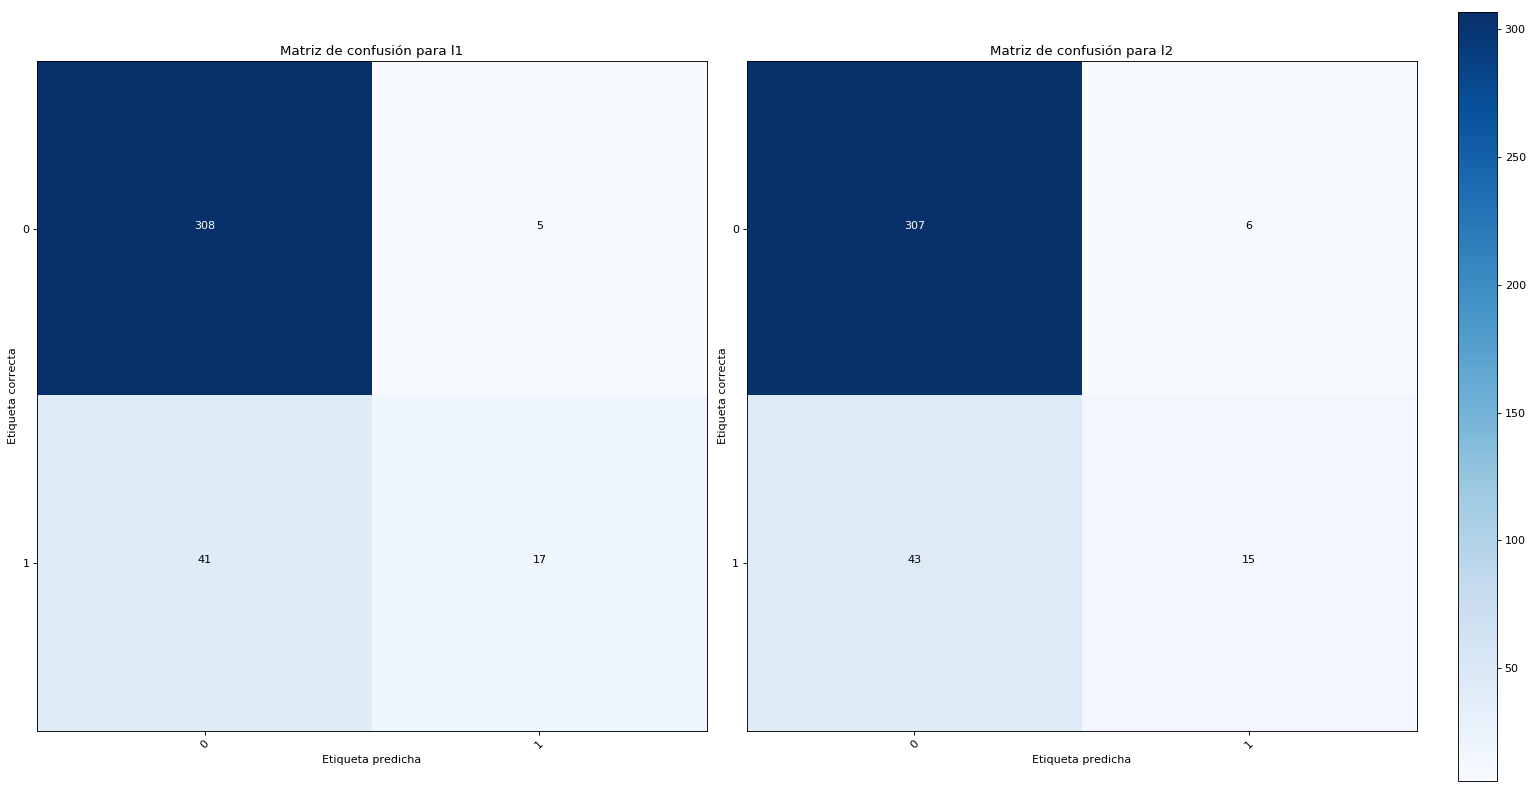

In [45]:
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
  
for idx, penalty in enumerate(('l1', 'l2'), start=1):
    exploring_params = {
        'C': [1./40., 1./30., 1./20., 1./10., 1./1., 1./0.9, 1./0.8, 1./0.5, 1./0.1, 1./0.01],  # Tasa de regularización
        'tol': [1e-3, 1e-5], 
        'max_iter': [10000, 15000, 20000]
    }    
    #poly_features = PolynomialFeatures(polynomial_degree)
    #poly_features.fit(X_train_feature)
    #X_poly_train = poly_features.transform(X_train_feature)
    #X_poly_test = poly_features.transform(X_test_feature)
    
    m = LogisticRegression(penalty=penalty)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='roc_auc')
    model.fit(X_train, y_train)
    
    print("####################################################################")
    print("    Exploración de hiperparámetros para función de coste \"%s\"    " % penalty, end="\n")
    print("####################################################################\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("============================================================================================================", end="\n\n")

    plt.subplot(1, 2, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=[0,1], title="Matriz de confusión para %s" % penalty)

---
## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

In [46]:
penalty = 'l1'  # TODO: Tipo de regularización: l1 (valor absoluto), l2 (cuadrados), elasticnet (l1 + l2).
C = 1./0.9      # TODO: Parámetro de regularización. También denominado como parámetro `lambda`.
max_iter = 20000 # TODO: Cantidad máxima de iteraciones del algoritmo
tol = 0.001      #TODO: Precisión del algoritmo (error mínimo entre una iteración y la siguiente)

model = LogisticRegression(penalty=penalty, C=1./alpha, max_iter=max_iter, tol=tol)
model.fit(X_train, y_train)

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_val, y_val)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train)))
print('Exactitud para validación: %.2f' % accuracy_score(y_test, model.predict(X_test)))

Exactitud para entrenamiento: 0.85
Exactitud para validación: 0.87


### Matriz de confusión

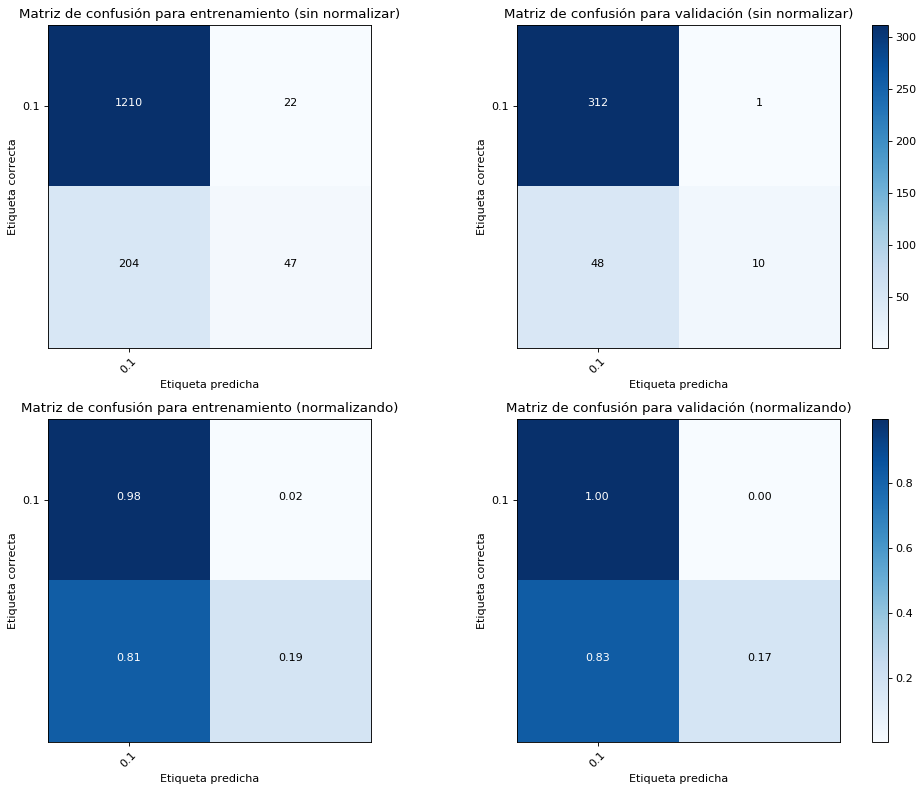

In [47]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                classes=[0.1],title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                classes=[0.1],normalize=True,title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)),
                classes=[0.1],title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)),
                classes=[0.1], normalize=True,title='Matriz de confusión para validación (normalizando)')
plt.show();

---
## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

In [48]:
# TODO: Redefinir umbral de clasificación a través de los resultados vistos por graficar curvas de ROC